<a href="https://colab.research.google.com/github/nauqcreen/Real-Time-ANPR-System-Using-Advanced-YOLO-and-OCR-Techniques-for-Efficient-Parking-Management/blob/main/notebooks/how-to-finetune-florence-2-on-detection-dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# Fine-tuning Florence-2 on Object Detection Dataset

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/florence-2/)
[![arXiv](https://img.shields.io/badge/arXiv-2311.06242-b31b1b.svg)](https://arxiv.org/abs/2311.06242)

Florence-2 is a lightweight vision-language model open-sourced by Microsoft under the MIT license. The model demonstrates strong zero-shot and fine-tuning capabilities across tasks such as captioning, object detection, grounding, and segmentation.

![Florence-2 Figure.1](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/florence-2-figure-1.png)

*Figure 1. Illustration showing the level of spatial hierarchy and semantic granularity expressed by each task. Source: Florence-2: Advancing a Unified Representation for a Variety of Vision Tasks.*

The model takes images and task prompts as input, generating the desired results in text format. It uses a DaViT vision encoder to convert images into visual token embeddings. These are then concatenated with BERT-generated text embeddings and processed by a transformer-based multi-modal encoder-decoder to generate the response.

![Florence-2 Figure.2](https://storage.googleapis.com/com-roboflow-marketing/notebooks/examples/florence-2-figure-2.png)

*Figure 2. Overview of Florence-2 architecture. Source: Florence-2: Advancing a Unified Representation for a Variety of Vision Tasks.*



## Setup

### Configure your API keys

To fine-tune Florence-2, you need to provide your HuggingFace Token and Roboflow API key. Follow these steps:

- Open your [`HuggingFace Settings`](https://huggingface.co/settings) page. Click `Access Tokens` then `New Token` to generate new token.
- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy`. This will place your private key in the clipboard.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store HuggingFace Access Token under the name `HF_TOKEN`.
    - Store Roboflow API Key under the name `ROBOFLOW_API_KEY`.

### Select the runtime

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `L4 GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Sun Feb 16 16:40:25 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             49W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Download example data

**NOTE:** Feel free to replace our example image with your own photo.

In [2]:
!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!ls -lh

total 212K
-rw-r--r-- 1 root root 104K Jun  2  2023 dog.jpeg
-rw-r--r-- 1 root root 104K Jun  2  2023 dog.jpeg.1
drwxr-xr-x 1 root root 4.0K Feb 13 14:19 sample_data


In [3]:
EXAMPLE_IMAGE_PATH = "dog.jpeg"

## Download and configure the model

 Let's download the model checkpoint and configure it so that you can fine-tune it later on.

In [6]:
!pip install -q transformers flash_attn timm einops peft
!pip install -q roboflow git+https://github.com/roboflow/supervision.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [7]:
# @title Imports

import io
import os
import re
import json
import torch
import html
import base64
import itertools

import numpy as np
import supervision as sv

from google.colab import userdata
from IPython.core.display import display, HTML
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AdamW,
    AutoModelForCausalLM,
    AutoProcessor,
    get_scheduler
)
from tqdm import tqdm
from typing import List, Dict, Any, Tuple, Generator
from peft import LoraConfig, get_peft_model
from PIL import Image
from roboflow import Roboflow

Load the model using `AutoModelForCausalLM` and the processor using `AutoProcessor` classes from the transformers library. Note that you need to pass `trust_remote_code` as `True` since this model is not a standard transformers model.

In [8]:
CHECKPOINT = "microsoft/Florence-2-base-ft"
REVISION = 'refs/pr/6'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION).to(DEVICE)
processor = AutoProcessor.from_pretrained(CHECKPOINT, trust_remote_code=True, revision=REVISION)

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

Importing from timm.models.layers is deprecated, please import via timm.layers


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


## Run inference with pre-trained Florence-2 model

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


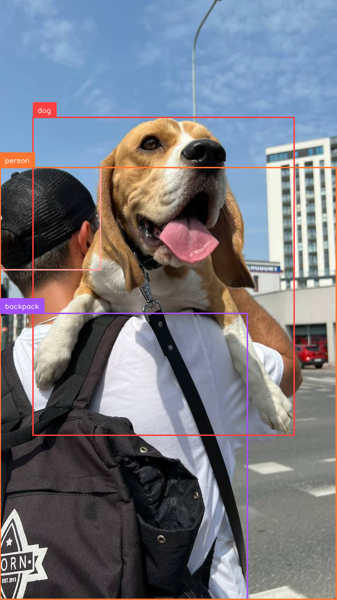

In [9]:
# @title Example object detection inference

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

In [10]:
# @title Example image captioning inference

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<DETAILED_CAPTION>"
text = "<DETAILED_CAPTION>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
response

{'<DETAILED_CAPTION>': 'In this image we can see a person wearing a bag and holding a dog. In the background there are buildings, poles and sky with clouds.'}

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


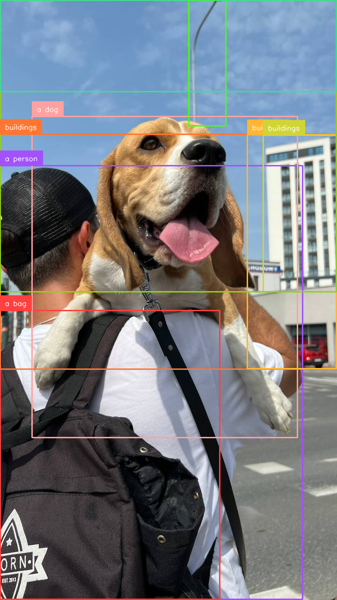

In [11]:
# @title Example caption to phrase grounding inference

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<CAPTION_TO_PHRASE_GROUNDING>"
text = "<CAPTION_TO_PHRASE_GROUNDING> In this image we can see a person wearing a bag and holding a dog. In the background there are buildings, poles and sky with clouds."

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

## Fine-tune Florence-2 on custom dataset

### Download dataset from Roboflow Universe

In [13]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="TCiLiCL5imitd7wJJMq6")
project = rf.workspace("sugical-tool").project("template-y4pid")
version = project.version(4)
dataset = version.download("florence2-od")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Template-4 in florence2-od:: 100%|██████████| 7292/7292 [00:01<00:00, 5691.35it/s]


In [14]:
!head -n 5 {dataset.location}/train/annotations.jsonl

{"image":"greenpack_0312_png.rf.2dddff8e46c4e6b0301a5171c9082452.jpg","prefix":"<OD>","suffix":"BSV<loc_191><loc_445><loc_396><loc_663>"}
{"image":"greenpack_0942_png.rf.2db1c138dd2a8303a772d49abe9015c0.jpg","prefix":"<OD>","suffix":"BSV<loc_408><loc_454><loc_632><loc_691>"}
{"image":"greenpack_0344_png.rf.2c633c02d9e3d96d24fb86425d7fc166.jpg","prefix":"<OD>","suffix":"BSV<loc_380><loc_92><loc_608><loc_347>"}
{"image":"Hung_0400_png.rf.2e1416538bfe325187d05312f81821c6.jpg","prefix":"<OD>","suffix":"BSV<loc_300><loc_646><loc_457><loc_724>"}
{"image":"carlong_0369_png.rf.2dc47f5a31b0f1df56be2fb4ed8ea4dc.jpg","prefix":"<OD>","suffix":"BSD<loc_438><loc_592><loc_659><loc_672>"}


In [15]:
# @title Define `DetectionsDataset` class

class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self) -> List[Dict[str, Any]]:
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = Image.open(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")


class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

In [16]:
# @title Initiate `DetectionsDataset` and `DataLoader` for train and validation subsets

BATCH_SIZE = 6
NUM_WORKERS = 0

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/train/annotations.jsonl",
    image_directory_path = f"{dataset.location}/train/"
)
val_dataset = DetectionDataset(
    jsonl_file_path = f"{dataset.location}/valid/annotations.jsonl",
    image_directory_path = f"{dataset.location}/valid/"
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [17]:
# @title Setup LoRA Florence-2 model

config = LoraConfig(
    r=8,
    lora_alpha=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=0.05,
    bias="none",
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
    revision=REVISION
)

peft_model = get_peft_model(model, config)
peft_model.print_trainable_parameters()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076


In [18]:
torch.cuda.empty_cache()

BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.



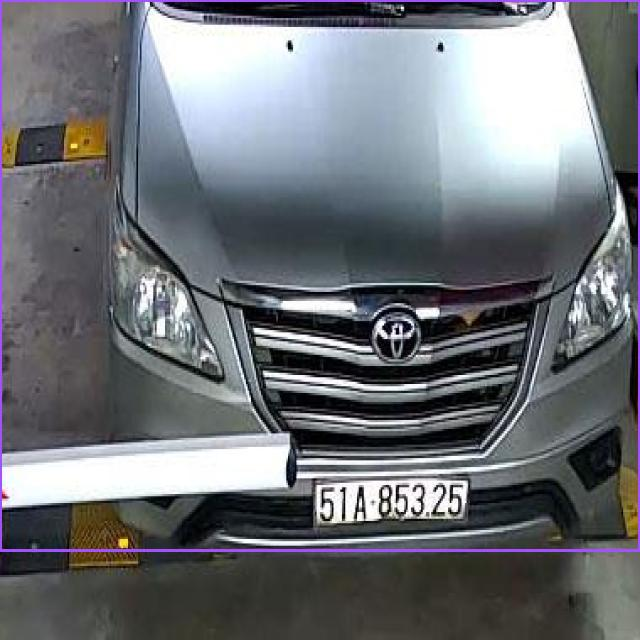
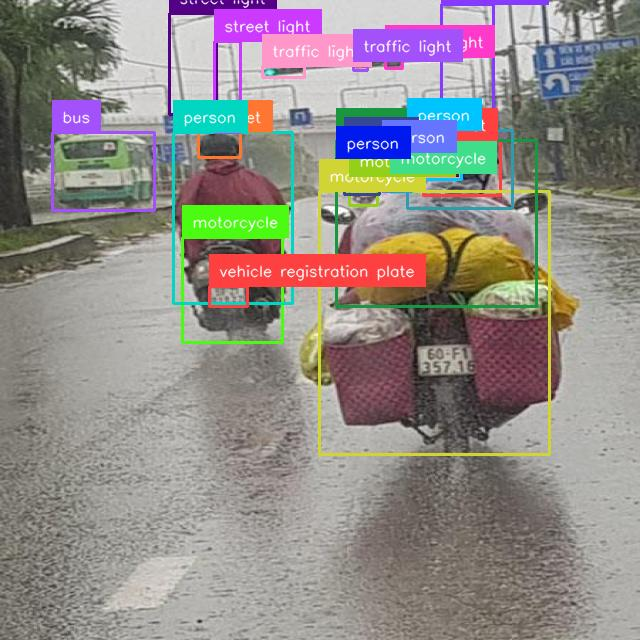
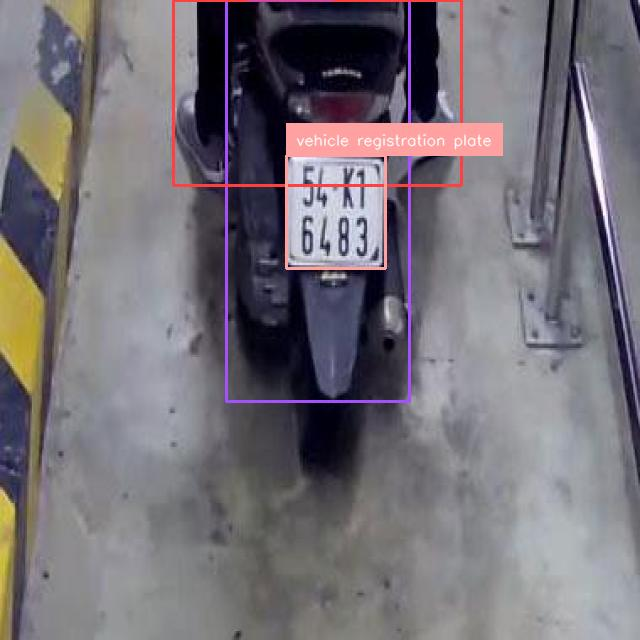
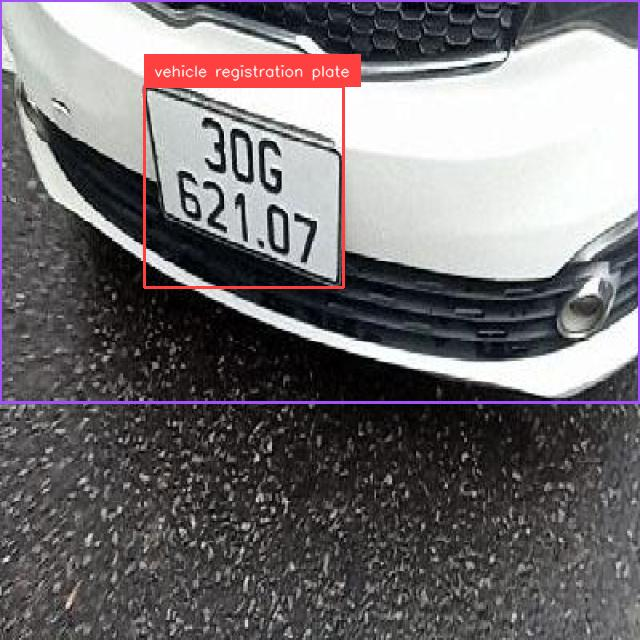

In [19]:
# @title Run inference with pre-trained Florence-2 model on validation dataset

def render_inline(image: Image.Image, resize=(128, 128)):
    """Convert image into inline html."""
    image.resize(resize)
    with io.BytesIO() as buffer:
        image.save(buffer, format='jpeg')
        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
        return f"data:image/jpeg;base64,{image_b64}"


def render_example(image: Image.Image, response):
    try:
        detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)
        image = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image.copy(), detections)
        image = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX).annotate(image, detections)
    except:
        print('failed to redner model response')
    return f"""
<div style="display: inline-flex; align-items: center; justify-content: center;">
    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />
    <p style="width:512px; margin:10px; font-size:small;">{html.escape(json.dumps(response))}</p>
</div>
"""


def render_inference_results(model, dataset: DetectionDataset, count: int):
    html_out = ""
    count = min(count, len(dataset))
    for i in range(count):
        image, data = dataset.dataset[i]
        prefix = data['prefix']
        suffix = data['suffix']
        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
        generated_ids = model.generate(
            input_ids=inputs["input_ids"],
            pixel_values=inputs["pixel_values"],
            max_new_tokens=1024,
            num_beams=3
        )
        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
        answer = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
        html_out += render_example(image, answer)

    display(HTML(html_out))

render_inference_results(peft_model, val_dataset, 4)

## Fine-tune Florence-2 on custom object detection dataset

In [20]:
# @title Define train loop

def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    render_inference_results(peft_model, val_loader.dataset, 6)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(DEVICE)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward(), optimizer.step(), lr_scheduler.step(), optimizer.zero_grad()
            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(
                    text=answers,
                    return_tensors="pt",
                    padding=True,
                    return_token_type_ids=False
                ).input_ids.to(DEVICE)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            print(f"Average Validation Loss: {avg_val_loss}")

            render_inference_results(peft_model, val_loader.dataset, 6)

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"
        os.makedirs(output_dir, exist_ok=True)
        model.save_pretrained(output_dir)
        processor.save_pretrained(output_dir)

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to 


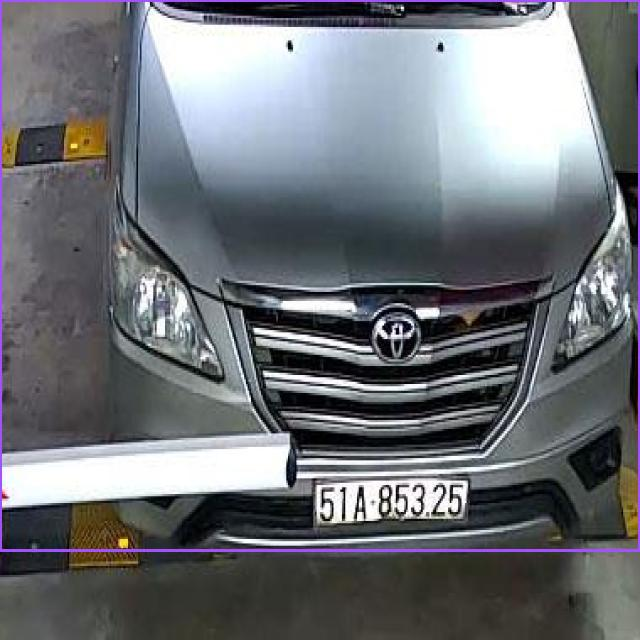
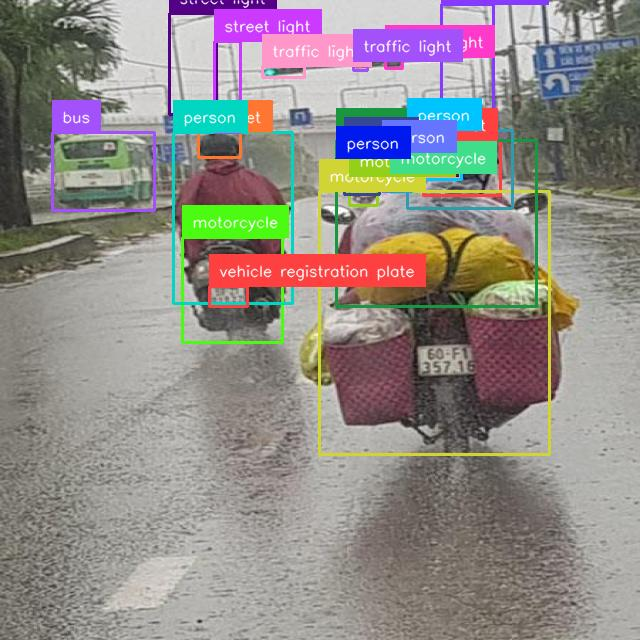
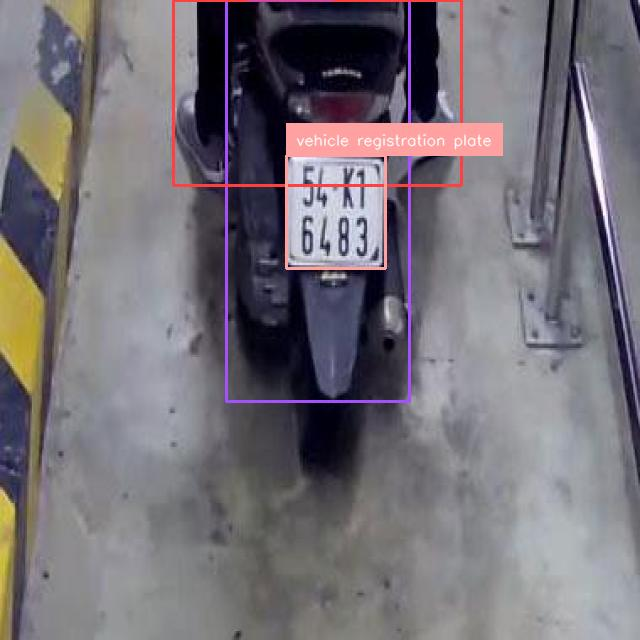
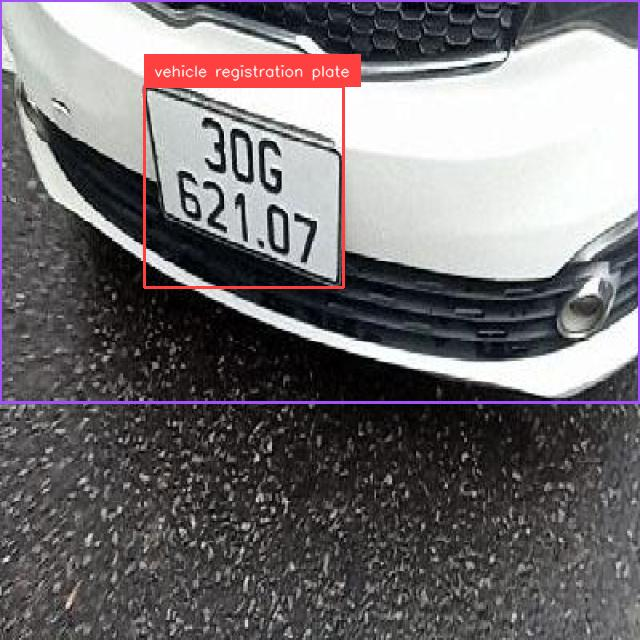
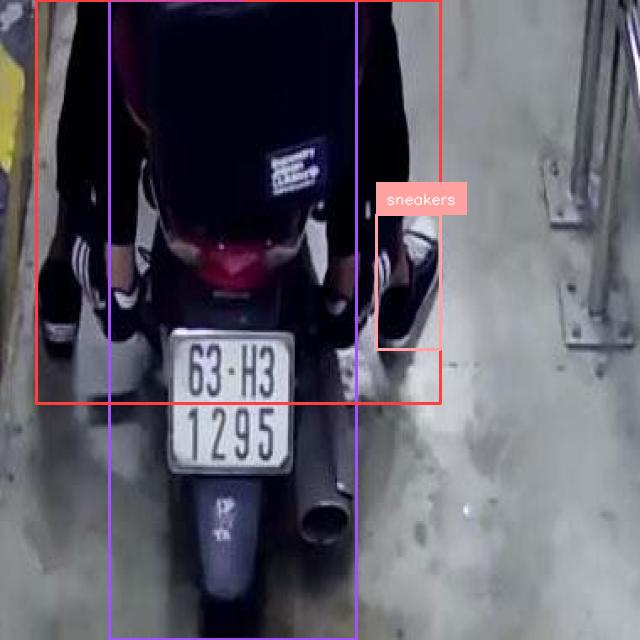
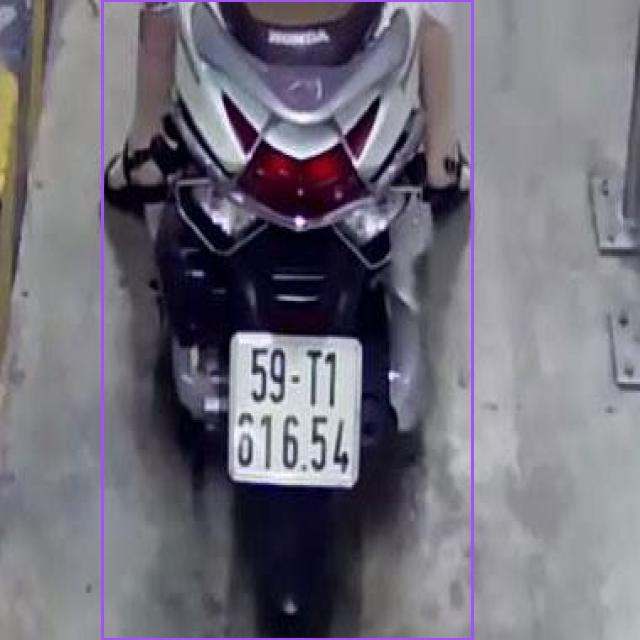

Training Epoch 1/18:   2%|▏         | 19/798 [00:14<09:56,  1.31it/s]

In [ ]:
# @title Run train loop

%%time

EPOCHS = 18
LR = 5e-6

train_model(train_loader, val_loader, peft_model, processor, epochs=EPOCHS, lr=LR)

## Fine-tuned model evaluation

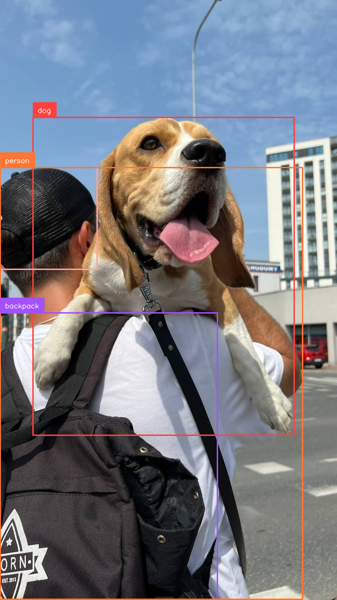

In [ ]:
# @title Check if the model can still detect objects outside of the custom dataset

image = Image.open(EXAMPLE_IMAGE_PATH)
task = "<OD>"
text = "<OD>"

inputs = processor(text=text, images=image, return_tensors="pt").to(DEVICE)
generated_ids = peft_model.generate(
    input_ids=inputs["input_ids"],
    pixel_values=inputs["pixel_values"],
    max_new_tokens=1024,
    num_beams=3
)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
response = processor.post_process_generation(generated_text, task=task, image_size=(image.width, image.height))
detections = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, response, resolution_wh=image.size)

bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
label_annotator = sv.LabelAnnotator(color_lookup=sv.ColorLookup.INDEX)

image = bounding_box_annotator.annotate(image, detections)
image = label_annotator.annotate(image, detections)
image.thumbnail((600, 600))
image

**NOTE:** It seems that the model can still detect classes that don't belong to our custom dataset.

In [ ]:
# @title Collect predictions

PATTERN = r'([a-zA-Z0-9 ]+ of [a-zA-Z0-9 ]+)<loc_\d+>'

def extract_classes(dataset: DetectionDataset):
    class_set = set()
    for i in range(len(dataset.dataset)):
        image, data = dataset.dataset[i]
        suffix = data["suffix"]
        classes = re.findall(PATTERN, suffix)
        class_set.update(classes)
    return sorted(class_set)

CLASSES = extract_classes(train_dataset)

targets = []
predictions = []

for i in range(len(val_dataset.dataset)):
    image, data = val_dataset.dataset[i]
    prefix = data['prefix']
    suffix = data['suffix']

    inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)
    generated_ids = model.generate(
        input_ids=inputs["input_ids"],
        pixel_values=inputs["pixel_values"],
        max_new_tokens=1024,
        num_beams=3
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    prediction = processor.post_process_generation(generated_text, task='<OD>', image_size=image.size)
    prediction = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, prediction, resolution_wh=image.size)
    prediction = prediction[np.isin(prediction['class_name'], CLASSES)]
    prediction.class_id = np.array([CLASSES.index(class_name) for class_name in prediction['class_name']])
    prediction.confidence = np.ones(len(prediction))

    target = processor.post_process_generation(suffix, task='<OD>', image_size=image.size)
    target = sv.Detections.from_lmm(sv.LMM.FLORENCE_2, target, resolution_wh=image.size)
    target.class_id = np.array([CLASSES.index(class_name) for class_name in target['class_name']])

    targets.append(target)
    predictions.append(prediction)

In [ ]:
# @title Calculate mAP
mean_average_precision = sv.MeanAveragePrecision.from_detections(
    predictions=predictions,
    targets=targets,
)

print(f"map50_95: {mean_average_precision.map50_95:.2f}")
print(f"map50: {mean_average_precision.map50:.2f}")
print(f"map75: {mean_average_precision.map75:.2f}")

map50_95: 0.49
map50: 0.53
map75: 0.53


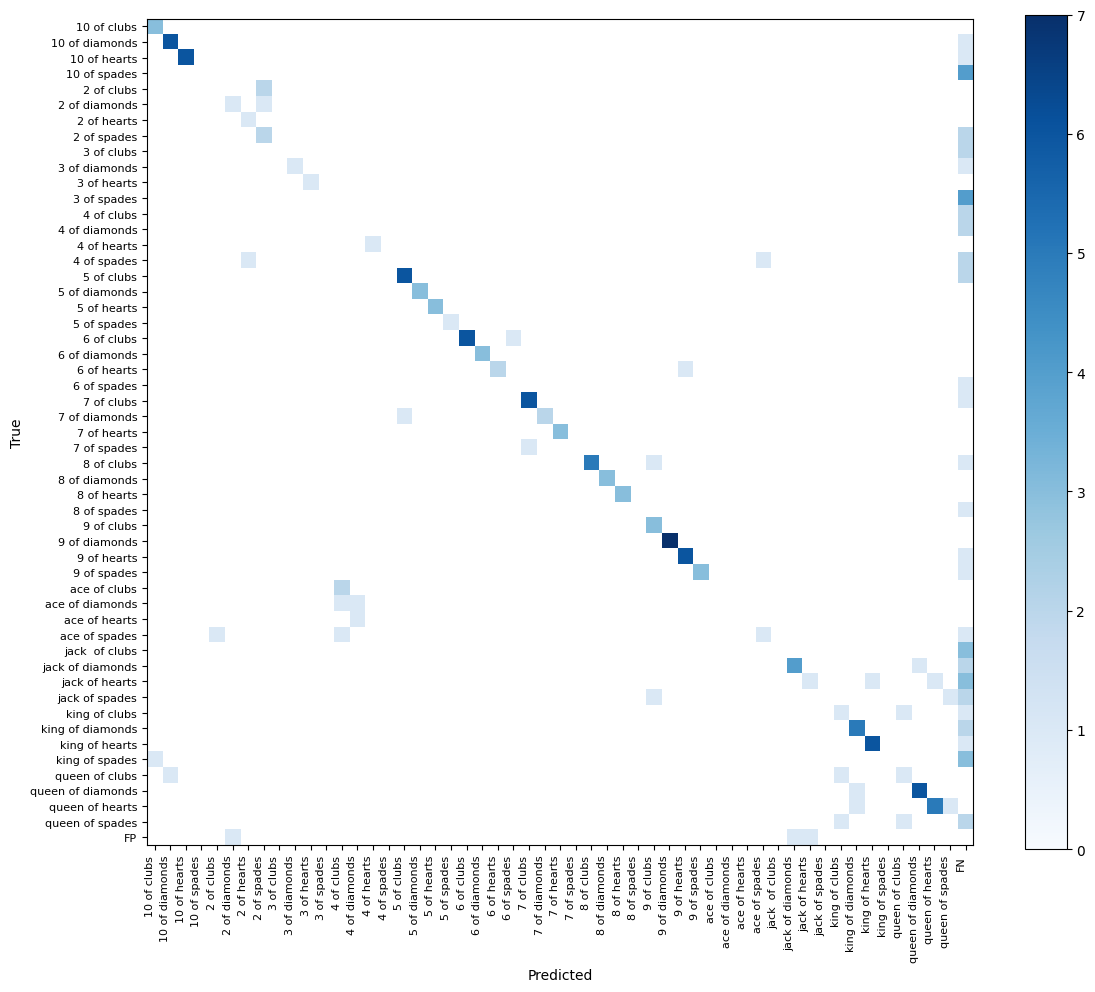

In [ ]:
# @title Calculate Confusion Matrix
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=CLASSES
)

_ = confusion_matrix.plot()

## Save fine-tuned model on hard drive

In [ ]:
peft_model.save_pretrained("/content/florence2-lora")
processor.save_pretrained("/content/florence2-lora/")
!ls -la /content/florence2-lora/

total 11432
drwxr-xr-x 2 root root    4096 Jun 26 21:43 .
drwxr-xr-x 1 root root    4096 Jun 26 21:43 ..
-rw-r--r-- 1 root root     746 Jun 26 21:43 adapter_config.json
-rw-r--r-- 1 root root 7747264 Jun 26 21:43 adapter_model.safetensors
-rw-r--r-- 1 root root   22410 Jun 26 21:43 added_tokens.json
-rw-r--r-- 1 root root  456318 Jun 26 21:43 merges.txt
-rw-r--r-- 1 root root     947 Jun 26 21:43 preprocessor_config.json
-rw-r--r-- 1 root root    5102 Jun 26 21:43 README.md
-rw-r--r-- 1 root root  146627 Jun 26 21:43 special_tokens_map.json
-rw-r--r-- 1 root root  197658 Jun 26 21:43 tokenizer_config.json
-rw-r--r-- 1 root root 2297961 Jun 26 21:43 tokenizer.json
-rw-r--r-- 1 root root  798293 Jun 26 21:43 vocab.json


## Upload model to Roboflow (optional)

You can deploy your Florence-2 object detection model on your own hardware (i.e. a cloud GPu server or an NVIDIA Jetson) with Roboflow Inference, an open source computer vision inference server.

To deploy your model, you will need a [free Roboflow account](https://app.roboflow.com).

To get started, [create a new Project in Roboflow](https://docs.roboflow.com/datasets/create-a-project) if you don't already have one. Then, upload the dataset you used to train your model. Then, create a dataset Version, which is a snapshot of your dataset with which your model will be associated in Roboflow.

You can read our full [Deploy Florence-2 with Roboflow](https://blog.roboflow.com/deploy-florence-2-with-roboflow/) guide for step-by-step instructions of these steps.

Once you have trained your model A, you can upload it to Roboflow using the following code:

In [ ]:
import roboflow

rf = Roboflow(api_key="API_KEY")
project = rf.workspace("workspace-id").project("project-id")
version = project.version(VERSION)

version.deploy(model_type="florence-2", model_path="/content/florence2-lora")

Above, replace:

- API_KEY with your [Roboflow API key](https://docs.roboflow.com/api-reference/authentication#retrieve-an-api-key).
- workspace-id and project-id with your [workspace and project IDs](https://docs.roboflow.com/api-reference/workspace-and-project-ids).
- VERSION with your project version.

If you are not using our notebook, replace /content/florence2-lora with the directory where you saved your model weights.

When you run the code above, the model will be uploaded to Roboflow. It will take a few minutes for the model to be processed before it is ready for use.

Your model will be uploaded to Roboflow.

## Deploy to your hardware

Once your model has been processed, you can download it to any device on which you want to deploy your model. Deployment is supported through Roboflow Inference, our open source computer vision inference server.

Inference can be run as a microservice with Docker, ideal for large deployments where you may need a centralized server on which to run inference, or when you want to run Inference in an isolated container. You can also directly integrate Inference into your project through the Inference Python SDK.

For this guide, we will show how to deploy the model with the Python SDK.

First, install inference:

In [ ]:
!pip install inference

Then, create a new Python file and add the following code:

In [ ]:
import os
from inference import get_model
from PIL import Image
import json

lora_model = get_model("model-id/version-id", api_key="KEY")

image = Image.open("containers.png")
response = lora_model.infer(image)
print(response)

In the code avove, we load our model, run it on an image, then plot the predictions with the supervision Python package.

When you first run the code, your model weights will be downloaded and cached to your device for subsequent runs. This process may take a few minutes depending on the strength of your internet connection.

# Congratulations

⭐️ If you enjoyed this notebook, [**star the Roboflow Notebooks repo**](https://https://github.com/roboflow/notebooks) (and [**supervision**](https://github.com/roboflow/supervision) while you're at it) and let us know what tutorials you'd like to see us do next. ⭐️